# Part 1: Data Acquisition & Preprocessing

**Objective**: Acquire and preprocess S&P 500 stock price data for portfolio analysis.

**Key Tasks**:
1. Scrape top 100 S&P 500 tickers by market capitalization
2. Download 5 years of End-of-Day OHLCV data
3. Clean and align data to uniform trading calendar
4. Compute daily log returns

**Deliverables**:
- `prices`: Adjusted close price matrix (DataFrame)
- `log_returns`: Daily log returns matrix (DataFrame)
- Complete code workflow for data acquisition and preprocessing

In [1]:
# Import required libraries
import yfinance as yf
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')

print("Libraries imported successfully!")

Libraries imported successfully!


## Task 1: Scrape Top 100 S&P 500 Tickers by Market Cap

In [2]:
# Get S&P 500 tickers from Wikipedia and select top 100 by market cap
def get_sp500_tickers():
    """Scrape S&P 500 tickers from Wikipedia"""
    url = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'
    tables = pd.read_html(url)
    sp500_table = tables[0]
    tickers = sp500_table['Symbol'].str.replace('.', '-').tolist()
    return tickers

# Get all S&P 500 tickers
sp500_tickers = get_sp500_tickers()
print(f"Found {len(sp500_tickers)} S&P 500 tickers")

# Get market caps to select top 100
print("Getting market capitalizations...")
market_caps = {}

# Process efficiently - check first 150 tickers
for ticker in sp500_tickers[:150]:
    try:
        stock = yf.Ticker(ticker)
        info = stock.info
        market_cap = info.get('marketCap', 0)
        if market_cap > 0:
            market_caps[ticker] = market_cap
    except:
        continue

# Sort by market cap and get top 100
sorted_tickers = sorted(market_caps.items(), key=lambda x: x[1], reverse=True)
top_100_tickers = [ticker for ticker, _ in sorted_tickers[:100]]

print(f"✓ Selected top 100 tickers by market cap")
print(f"Sample tickers: {top_100_tickers[:5]}..." +
      f"{top_100_tickers[-5:]}")
print(f"Total: {len(top_100_tickers)} tickers")

Found 503 S&P 500 tickers
Getting market capitalizations...
✓ Selected top 100 tickers by market cap
Sample tickers: ['AAPL', 'GOOG', 'GOOGL', 'AMZN', 'AVGO']...['STZ', 'AWK', 'AEE', 'ADM', 'AVB']
Total: 100 tickers
✓ Selected top 100 tickers by market cap
Sample tickers: ['AAPL', 'GOOG', 'GOOGL', 'AMZN', 'AVGO']...['STZ', 'AWK', 'AEE', 'ADM', 'AVB']
Total: 100 tickers


## Task 2: Download EOD OHLCV Data (5 Years)

In [3]:
# Download 5 years of EOD OHLCV data
from datetime import datetime, timedelta

# Define date range
end_date = datetime.now()
start_date = end_date - timedelta(days=5*365)

print(f"Downloading data from {start_date.strftime('%Y-%m-%d')} to " +
      f"{end_date.strftime('%Y-%m-%d')} for {len(top_100_tickers)} tickers...")
# Download data for all tickers
raw_data = yf.download(
    tickers=top_100_tickers,
    start=start_date.strftime('%Y-%m-%d'),
    end=end_date.strftime('%Y-%m-%d'),
    group_by='ticker',
    auto_adjust=True,
    prepost=False,
    threads=True
)

print(f"✓ Download completed!")
print(f"Data shape: {raw_data.shape}")
print(f"Date range: {raw_data.index[0]} to {raw_data.index[-1]}")

# Display first 5 rows of raw data
print("Displaying first 5 rows of raw data:")
print(raw_data.head(5))

[*********************100%***********************]  100 of 100 completed

✓ Download completed!
Data shape: (1254, 500)
Date range: 2020-08-07 00:00:00 to 2025-08-05 00:00:00
Displaying first 5 rows of raw data:
Ticker            DXCM                                               \
Price             Open        High         Low       Close   Volume   
Date                                                                  
2020-08-07  110.220001  114.057503  108.754997  110.175003  3715200   
2020-08-10  109.827499  109.957497  101.552498  105.305000  4454800   
2020-08-11  103.752502  104.802498  100.787498  102.787498  3273200   
2020-08-12  103.050003  107.605003  103.050003  106.972504  2465200   
2020-08-13  108.199997  109.997498  107.684998  108.820000  2421600   

Ticker              BR                                               ...  \
Price             Open        High         Low       Close   Volume  ...   
Date                                                                 ...   
2020-08-07  124.052006  125.266405  123.555215  124.429207   7682

## Task 3: Clean and Align Data to Uniform Calendar

Extracting and cleaning adjusted close prices...
Cleaning data...
✓ Clean price data: 1254 dates × 100 tickers
Date range: 2020-08-07 00:00:00 to 2025-08-05 00:00:00
Final tickers count: 100
Displaying first 5 rows of the cleaned price data:
                  AAPL       GOOG      GOOGL        AMZN       AVGO  \
Date                                                                  
2020-08-07  108.203766  74.282944  74.471870  158.373001  28.915100   
2020-08-10  109.776505  74.362968  74.394836  157.408005  29.041964   
2020-08-11  106.511765  73.578644  73.585678  154.033493  28.746538   
2020-08-12  110.051590  74.885864  74.912727  158.112000  29.599096   
2020-08-13  111.999245  75.473877  75.380417  158.050995  29.224720   

                 BRK-B        COST       ABBV        BAC        CVX  ...  \
Date                                                                 ...   
2020-08-07  209.479996  314.168182  75.978493  23.083565  69.710876  ...   
2020-08-10  212.580002  313.3294

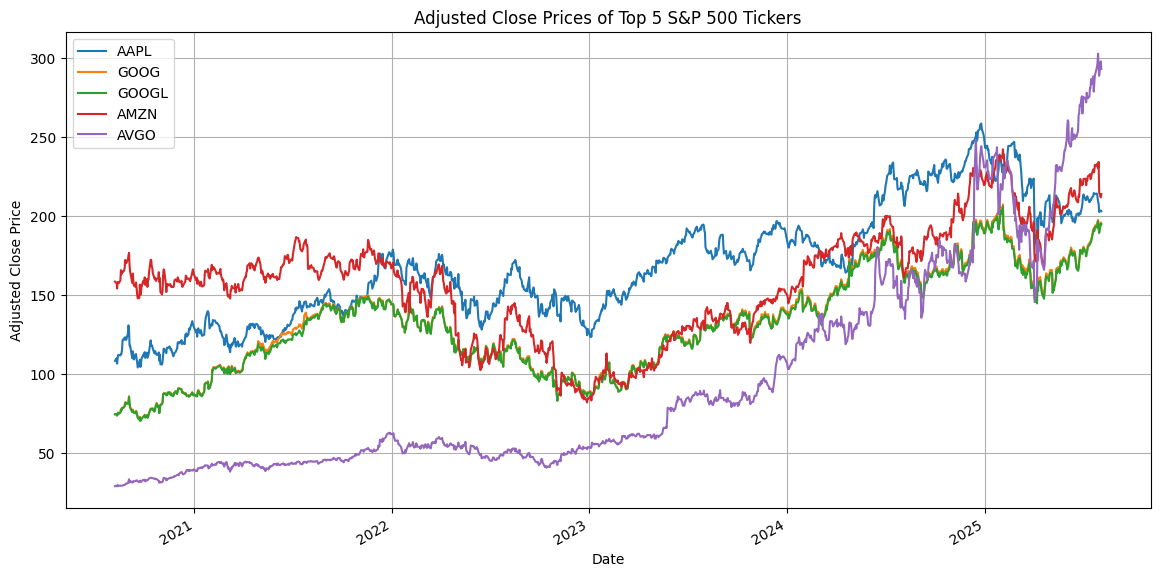

In [4]:
# Extract and clean adjusted close prices
print("Extracting and cleaning adjusted close prices...")

# Extract close prices for all tickers
if len(top_100_tickers) == 1:
    # Single ticker case
    prices = raw_data[['Close']].copy()
    prices.columns = top_100_tickers
else:
    # Multiple tickers case
    prices = pd.DataFrame(index=raw_data.index)
    for ticker in top_100_tickers:
        if ticker in raw_data.columns.get_level_values(0):
            prices[ticker] = raw_data[ticker]['Close']

# Clean the data
print("Cleaning data...")
# Remove columns with all NaN values
prices = prices.dropna(axis=1, how='all')
# Remove rows with all NaN values
prices = prices.dropna(how='all')
# Forward fill missing values
prices = prices.fillna(method='ffill')
# Backward fill remaining NaN values
prices = prices.fillna(method='bfill')

final_tickers = prices.columns.tolist()
print(f"✓ Clean price data: {prices.shape[0]} dates × " +
      f"{prices.shape[1]} tickers")
print(f"Date range: {prices.index[0]} to {prices.index[-1]}")
print(f"Final tickers count: {len(final_tickers)}")

# Display uniformly formatted output
print("Displaying first 5 rows of the cleaned price data:")
print(prices.head(5))

# Plot the first 5 tickers to visualize the data
print("Plotting first 5 tickers...")
prices.iloc[:, :5].plot(figsize=(14, 7))
plt.title('Adjusted Close Prices of Top 5 S&P 500 Tickers')
plt.xlabel('Date')
plt.ylabel('Adjusted Close Price')
plt.legend(loc='upper left')
plt.grid()
plt.show()

## Task 4: Compute Daily Log Returns

Formula: r_t = ln(P_t / P_{t-1}) = ln(P_t) - ln(P_{t-1})

Computing daily log returns...
✓ Log returns computed successfully!
Shape: (1253, 100)
Date range: 2020-08-10 00:00:00 to 2025-08-05 00:00:00

Summary statistics:
Mean daily return: 0.000565
Std daily return: 0.019336
Data quality - NaN values: 0
Data quality - Infinite values: 0
Displaying first 5 rows of log returns:
                AAPL      GOOG     GOOGL      AMZN      AVGO     BRK-B  \
Date                                                                     
2020-08-10  0.014430  0.001077 -0.001035 -0.006112  0.004378  0.014690   
2020-08-11 -0.030191 -0.010603 -0.010936 -0.021671 -0.010224  0.000376   
2020-08-12  0.032694  0.017610  0.017873  0.026134  0.029226  0.002724   
2020-08-13  0.017543  0.007821  0.006224 -0.000386 -0.012729 -0.005926   
2020-08-14 -0.000892 -0.007085 -0.007957 -0.004121 -0.004869 -0.004823   

                COST      ABBV       BAC       CVX  ...      ACGL         A  \
Date                                                ...                       
20

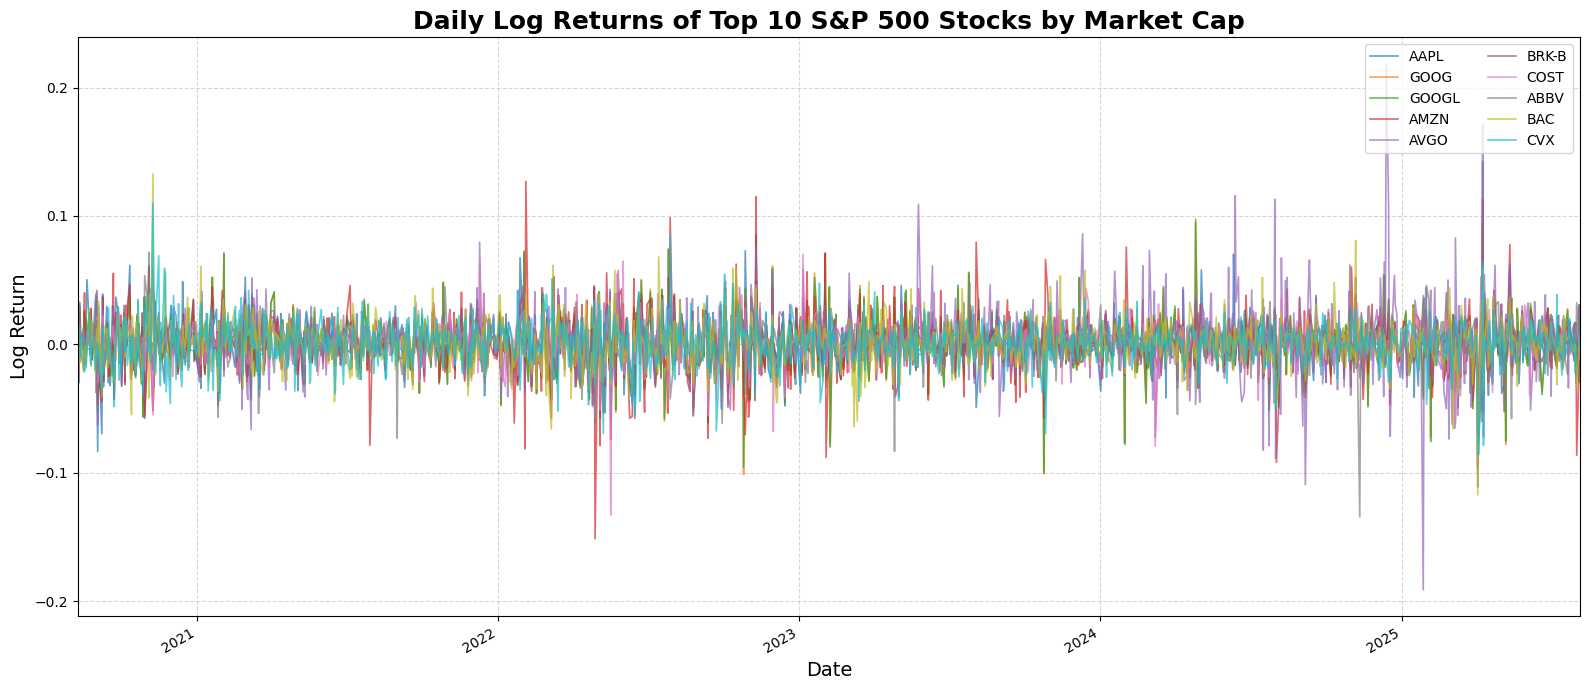

In [5]:
# Compute daily log returns: r_t = ln(P_t / P_{t-1})
print("Computing daily log returns...")

log_returns = np.log(prices / prices.shift(1))
log_returns = log_returns.dropna()

# Clean any infinite or NaN values
log_returns.replace([np.inf, -np.inf], np.nan, inplace=True)
log_returns.fillna(method='ffill', inplace=True)
log_returns.fillna(0, inplace=True)

print(f"✓ Log returns computed successfully!")
print(f"Shape: {log_returns.shape}")
print(f"Date range: {log_returns.index[0]} to {log_returns.index[-1]}")

# Basic statistics
print(f"\nSummary statistics:")
print(f"Mean daily return: {log_returns.mean().mean():.6f}")
print(f"Std daily return: {log_returns.std().mean():.6f}")
print(f"Data quality - NaN values: {log_returns.isnull().sum().sum()}")
print(f"Data quality - Infinite values: {np.isinf(log_returns).sum().sum()}")

# Display first 5 rows of log returns
print("Displaying first 5 rows of log returns:")
print(log_returns.head(5))

# Plot log returns: cleaner and more informative visualization
import matplotlib.dates as mdates

plt.figure(figsize=(16, 7))
# Plot only a subset of tickers for clarity (e.g., top 10 by market cap)
top10 = top_100_tickers[:10]
log_returns[top10].plot(ax=plt.gca(), alpha=0.7, linewidth=1.2)

plt.title('Daily Log Returns of Top 10 S&P 500 Stocks by Market Cap', 
          fontsize=18, fontweight='bold')
plt.xlabel('Date', fontsize=14)
plt.ylabel('Log Return', fontsize=14)
plt.legend(top10, loc='upper right', ncol=2, fontsize=10, 
           frameon=True)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.xlim(log_returns.index[0], log_returns.index[-1])
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.show()

## Deliverables

In [6]:
# DELIVERABLE 1: prices - Adjusted close price matrix (DataFrame)
print("DELIVERABLE 1: prices")
print("=" * 40)
print(f"Type: {type(prices)}")
print(f"Shape: {prices.shape}")
print(f"Index: {prices.index[0]} to {prices.index[-1]}")
print(f"Columns: {len(prices.columns)} tickers")
print("\nSample data (first 5 rows, first 5 columns):")
display(prices.iloc[:5, :5])

print("\n" + "=" * 40)

# DELIVERABLE 2: log_returns - Daily log returns matrix (DataFrame) 
print("DELIVERABLE 2: log_returns")
print("=" * 40)
print(f"Type: {type(log_returns)}")
print(f"Shape: {log_returns.shape}")
print(f"Index: {log_returns.index[0]} to {log_returns.index[-1]}")
print(f"Columns: {len(log_returns.columns)} tickers")
print(f"Formula: r_t = ln(P_t / P_{{t-1}})")
print("\nSample data (first 5 rows, first 5 columns):")
display(log_returns.iloc[:5, :5])

print("\n" + "=" * 40)

# DELIVERABLE 3: This notebook - Data preprocessing script
print("DELIVERABLE 3: This notebook")
print("=" * 40)
print("Type: Jupyter Notebook (.ipynb)")
print("Contains all code and comments for data acquisition " +
      "and preprocessing")

DELIVERABLE 1: prices
Type: <class 'pandas.core.frame.DataFrame'>
Shape: (1254, 100)
Index: 2020-08-07 00:00:00 to 2025-08-05 00:00:00
Columns: 100 tickers

Sample data (first 5 rows, first 5 columns):


,AAPL,GOOG,GOOGL,AMZN,AVGO
Date,,,,,
2020-08-07,108.203766,74.282944,74.471870,158.373001,28.915100
2020-08-10,109.776505,74.362968,74.394836,157.408005,29.041964
2020-08-11,106.511765,73.578644,73.585678,154.033493,28.746538
2020-08-12,110.051590,74.885864,74.912727,158.112000,29.599096
2020-08-13,111.999245,75.473877,75.380417,158.050995,29.224720



DELIVERABLE 2: log_returns
Type: <class 'pandas.core.frame.DataFrame'>
Shape: (1253, 100)
Index: 2020-08-10 00:00:00 to 2025-08-05 00:00:00
Columns: 100 tickers
Formula: r_t = ln(P_t / P_{t-1})

Sample data (first 5 rows, first 5 columns):


,AAPL,GOOG,GOOGL,AMZN,AVGO
Date,,,,,
2020-08-10,0.014430,0.001077,-0.001035,-0.006112,0.004378
2020-08-11,-0.030191,-0.010603,-0.010936,-0.021671,-0.010224
2020-08-12,0.032694,0.017610,0.017873,0.026134,0.029226
2020-08-13,0.017543,0.007821,0.006224,-0.000386,-0.012729
2020-08-14,-0.000892,-0.007085,-0.007957,-0.004121,-0.004869



DELIVERABLE 3: This notebook
Type: Jupyter Notebook (.ipynb)
Contains all code and comments for data acquisition and preprocessing
